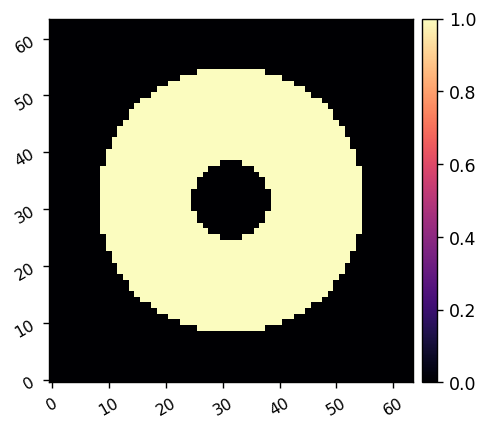

In [1]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
from IPython.display import clear_output
import time

from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
import h5py
import os
from pathlib import Path

import misc
from matplotlib.patches import Circle
from importlib import reload
reload(misc)

# data_dir = Path('C:/Users/Kian/Documents/data-files/disk-processing')
# data_dir = Path('/users/kianmilani/Documents/data-files/disk-processing')
data_dir = Path('/groups/douglase/kians-data-files/disk-processing')

wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

# define desired PSF dimensions and pixelscale in units of lambda/D
npsf=64
psf_pixelscale_mas = 20.8*u.mas/u.pix
psf_pixelscale_lamD = psf_pixelscale_mas.value / mas_per_lamD.value
psf_pixelscale = 13e-6 * psf_pixelscale_lamD/(1/2)
psf_pixelscale_m = psf_pixelscale*u.m/u.pix

polaxis = 10

ndisk = 64
disk_pixelscale_mas = 20.8*u.mas/u.pix
disk_pixelscale_lamD = (disk_pixelscale_mas/mas_per_lamD).value

band1_wavelength = 575e-9*u.m
iwa_band1 = 2.8
owa_band1 = 9.7

iwa = iwa_band1 * wavelength_c/band1_wavelength
owa = owa_band1 * wavelength_c/band1_wavelength

iwa_mas = iwa*mas_per_lamD
owa_mas = owa*mas_per_lamD

x,y = np.meshgrid(np.arange(-ndisk/2,ndisk/2) + 1/2, np.arange(-ndisk/2,ndisk/2)+1/2 )
r = np.sqrt(x**2 + y**2)*disk_pixelscale_lamD
mask = np.zeros((ndisk,ndisk))
mask[((r>iwa)*(r<owa))] = 1
misc.myimshow(mask)

In [2]:
fov_owa = owa_mas
fov_im = psf_pixelscale_mas * 64/2

print(fov_owa, fov_im)

486.8359175841816 mas 665.6 mas / pix


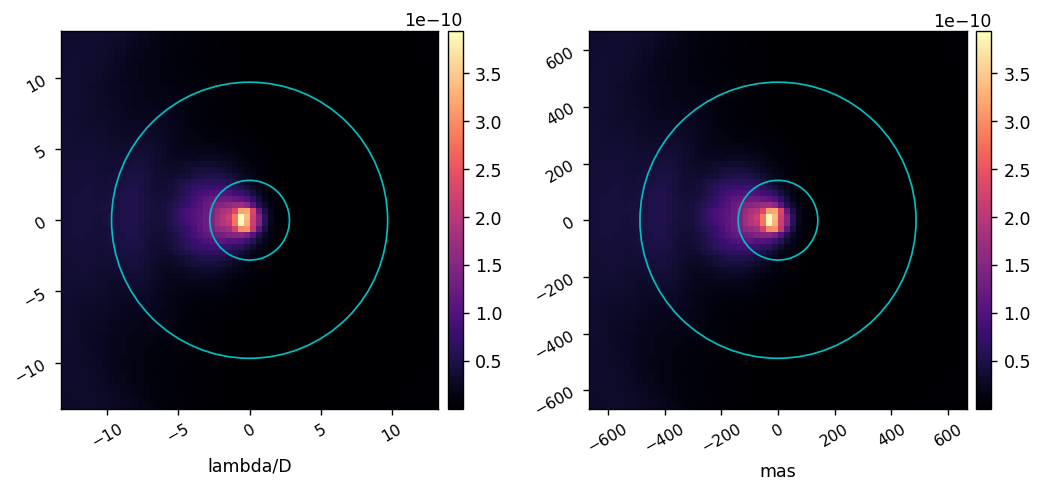

In [3]:
disk_fpath = data_dir/'disks'/'I_0_eps_eri.fits'

disk = fits.getdata(disk_fpath)
disk = misc.pad_or_crop(disk, ndisk)
disk_hdr = fits.getheader(disk_fpath)

patches1 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
misc.myimshow2(disk, disk, lognorm1=False, lognorm2=False, 
               pxscl1=disk_pixelscale_lamD, pxscl2=disk_pixelscale_mas, 
               patches1=patches1, patches2=patches2 )


In [ ]:
mask 

# Do the matrix multiplication

In [4]:
# ipsf_fpath = data_dir/'ipsfs'/'spc_wide_ipsf_matrix_polaxis{:d}_rtheta_v1.hdf5'.format(polaxis)
ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_20220920.hdf5'

f = h5py.File(ipsf_fpath, 'r')
ipsf_matrix = np.array(f['ipsf_matrix'])
f.close()

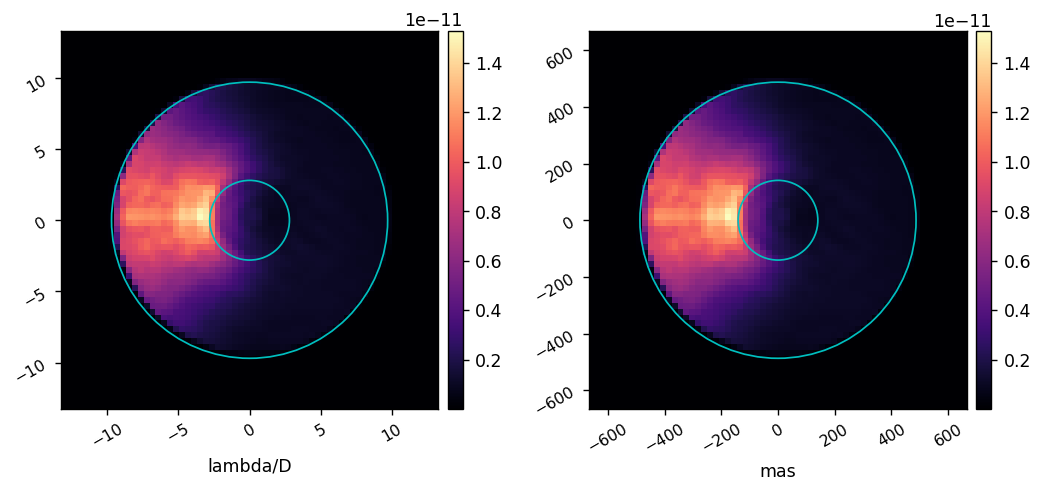

In [5]:
disk_sim = np.reshape(ipsf_matrix.dot(disk.flatten()), (npsf,npsf))

patches1 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
misc.myimshow2(disk_sim, disk_sim, lognorm1=False, lognorm2=False, 
               pxscl1=psf_pixelscale_lamD, pxscl2=psf_pixelscale_mas, 
               patches1=patches1, patches2=patches2 )

In [6]:
disk_sum = (mask*disk).sum()
im_sum = (mask*disk_sim).sum()

print(disk_sum, im_sum, im_sum/disk_sum)

2.4538987865587986e-08 5.734768958891776e-09 0.23370030542025225
